In [1]:
import numpy as np
import pandas as pd
import plotly 

import matplotlib.pyplot as plt
import matplotlib as mpl

import opentisim 
from opentisim import core
from opentisim import plot

from opentisim.liquidbulk.hydrogen_defaults import *
from opentisim.liquidbulk.hydrogen_objects import *

# plotly.tools.set_credentials_file(username='stephh', api_key='aYheUBjQH0kyWL5yo9E6')

# 0. Prepare inputs

In [2]:
startyear = 2020
lifecycle = 10
years = list(range(startyear, startyear + lifecycle))

## 0.1 Generate demand forecast scenario

In [3]:
scenario = 'permanent' #choice between permanent or random

demand = []
for year in years:
    if year < 2025:
        demand.append(2_000_000)
    else:
        demand.append(4_000_000)
scenario_data = {'year': years, 'volume': demand}



## 0.2 Generate vessels

In [4]:
# instantiate a commodity objects
opentisim.liquidbulk.commodity_lhydrogen_data['smallhydrogen_perc'] = 50
opentisim.liquidbulk.commodity_lhydrogen_data['largehydrogen_perc'] = 50

# instantiate a commodity objects
lhydrogen = opentisim.liquidbulk.Commodity(**opentisim.liquidbulk.commodity_lhydrogen_data)
lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

# instantiate vessels
Smallhydrogen = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.smallhydrogen_data)
Largehydrogen = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.largehydrogen_data)
Smallammonia = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.smallammonia_data)
Largeammonia = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.largeammonia_data)
Handysize = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.handysize_data)
Panamax = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.panamax_data)
VLCC = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instantiate terminal system

In [5]:
Terminal = opentisim.liquidbulk.System(
    startyear=startyear,
    lifecycle=lifecycle,
    elements=[lhydrogen] + vessels,
    operational_hours=16 * 365,
    terminal_supply_chain={'berth_jetty'},#'pipeline_jetty_-_terminal' , 'storage'}, #, 'mch_2_h2_retrieval'},
                           #'pipeline_terminal_-_hinterland'},
    debug=False,
    commodity_type_defaults=opentisim.liquidbulk.commodity_lhydrogen_data,
    storage_type_defaults=opentisim.liquidbulk.storage_lh2_data,
    kendall='E2/E2/n',
    allowable_waiting_service_time_ratio_berth=0.3,
    h2retrieval_type_defaults=opentisim.liquidbulk.h2retrieval_lh2_data)

Terminal.modelframe = list(range(startyear, startyear + lifecycle))
Terminal.revenues = []
Terminal.demurrage = []

In [6]:
Terminal.terminal_supply_chain
# print(Terminal.elements[0].scenario_data)
# Terminal.elements[0].plot_demand()
# Terminal.elements[0].largeammonia_perc


{'berth_jetty'}

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [7]:
Terminal.simulate()

## Report all elements

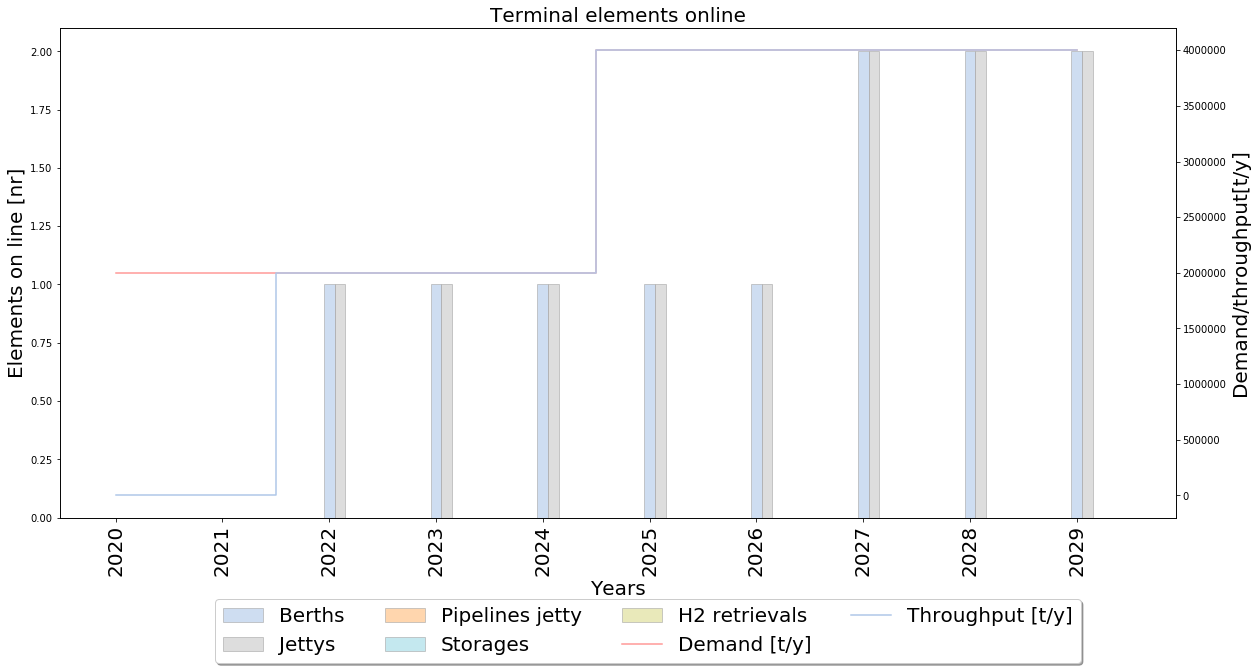

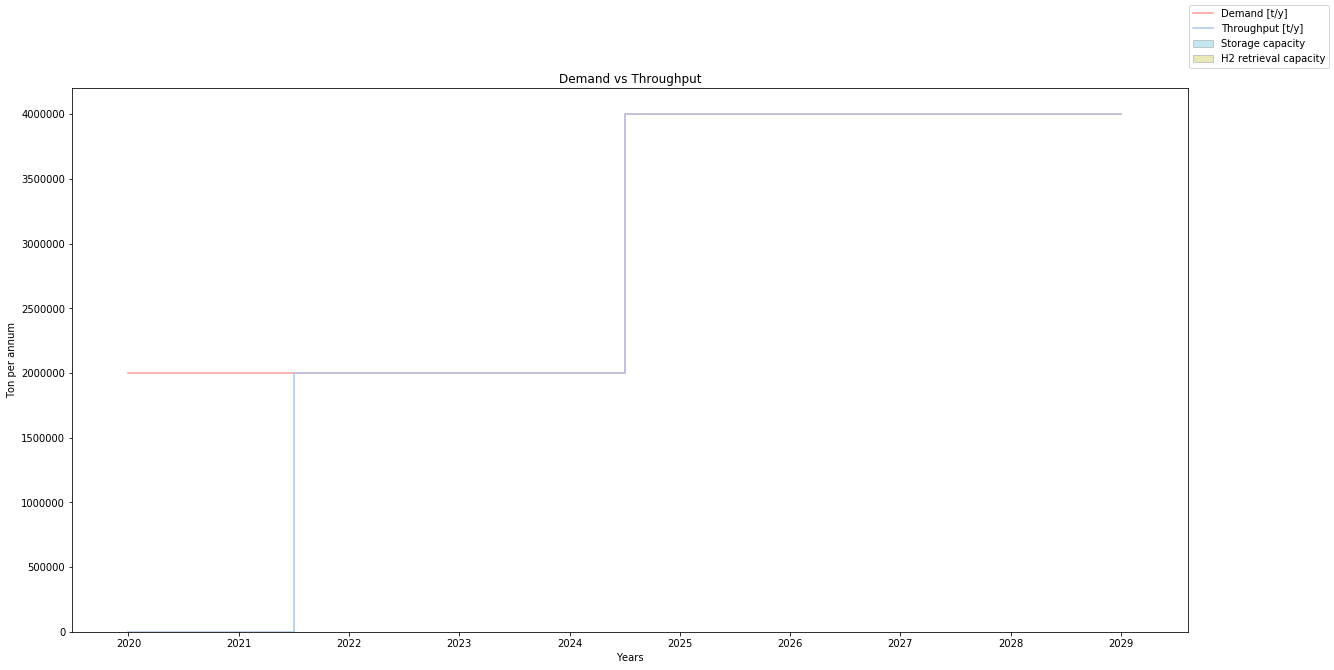

In [8]:
Terminal.terminal_elements_plot()
Terminal.demand_terminal_plot()

In [9]:
#Terminal.__dict__

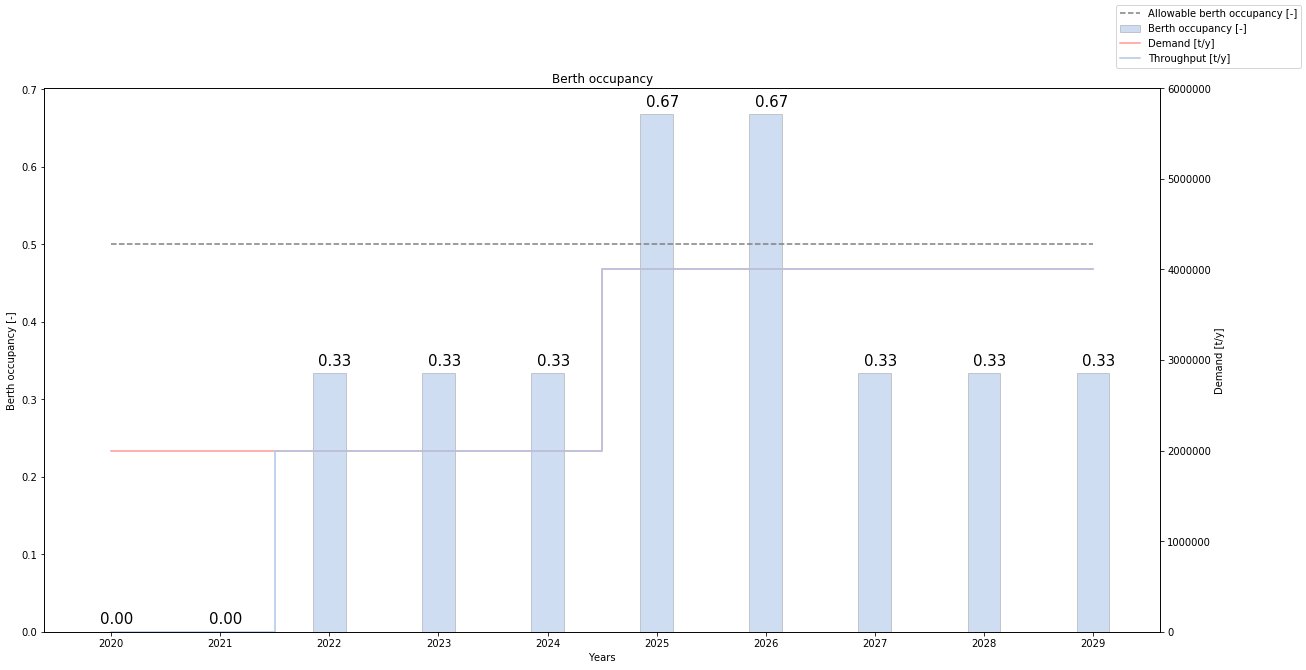

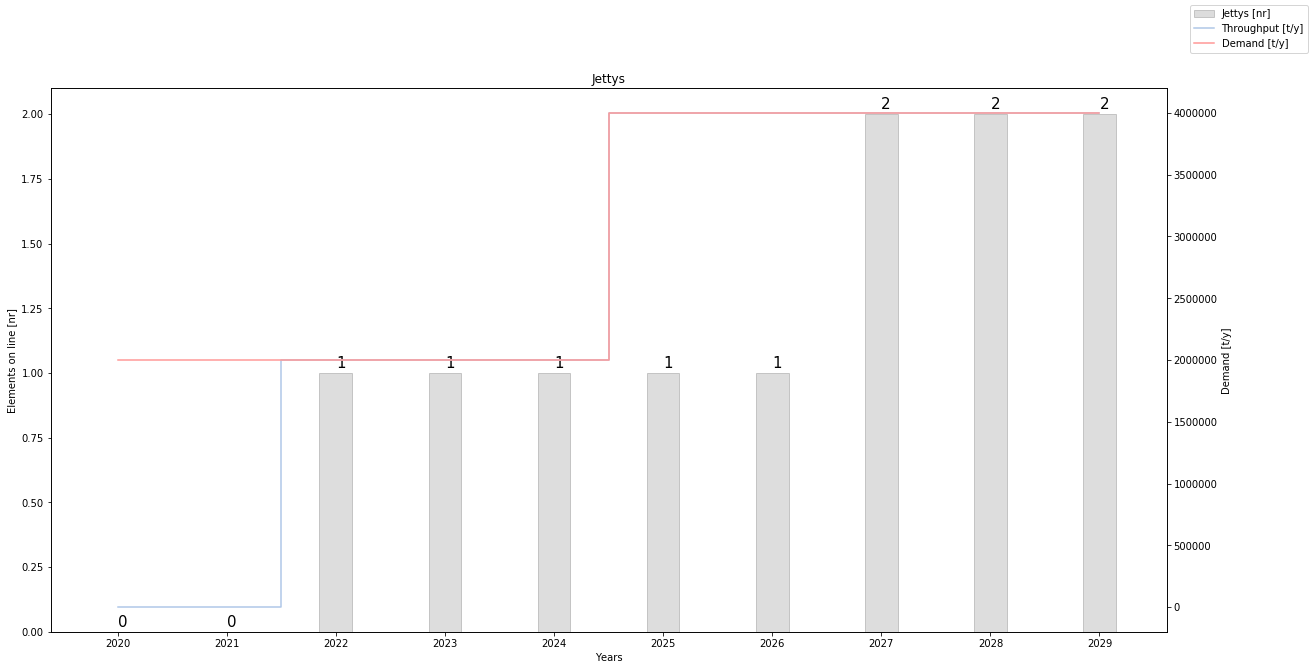

In [10]:
Terminal.terminal_occupancy_plot()
#Terminal.plant_occupancy_plot()
Terminal.Jetty_capacity_plot()
#Terminal.Pipeline1_capacity_plot() 
#Terminal.Storage_capacity_plot()
#Terminal.H2_capacity_plot() 
#Terminal.Pipeline2_capacity_plot()

# if True: 
#     # to plot the terminal occupany's 
#     Terminal.terminal_occupancy_plot() #occupancy of the berth 
#     Terminal.plant_occupancy_plot() #occupancy of the plant
    
#     # to plot the capacities of the different elements 
#     Terminal.Jetty_capacity_plot() #jetty
#     Terminal.Pipeline1_capacity_plot() #pipeline from jetty to storage
#     Terminal.Storage_capacity_plot() #storage
#     Terminal.H2_capacity_plot() # H2 retrieval
#     Terminal.Pipeline2_capacity_plot() #pipeline from H2 retrieval to hinterland        

In [11]:
# add cash flow information for each of the Terminal elements
Labour = opentisim.liquidbulk.Labour(**opentisim.liquidbulk.labour_data)
cash_flows, cash_flows_WACC_real = core.add_cashflow_elements(Terminal, Labour)
#print(cash_flows)
year = 2025

mask = cash_flows['year'] == year
if mask.any():
    capex = cash_flows.loc[mask, ['capex']]
    opex = cash_flows.loc[mask, ['maintenance', 'insurance', 'energy', 'demurrage', 'fuel', 'labour']]
    revenues = cash_flows.loc[mask, ['revenues']]

print(capex.values[0])
print(sum(opex.values[0]))
print(revenues.values[0])

[2376000.]
667700.0
[1960000000]


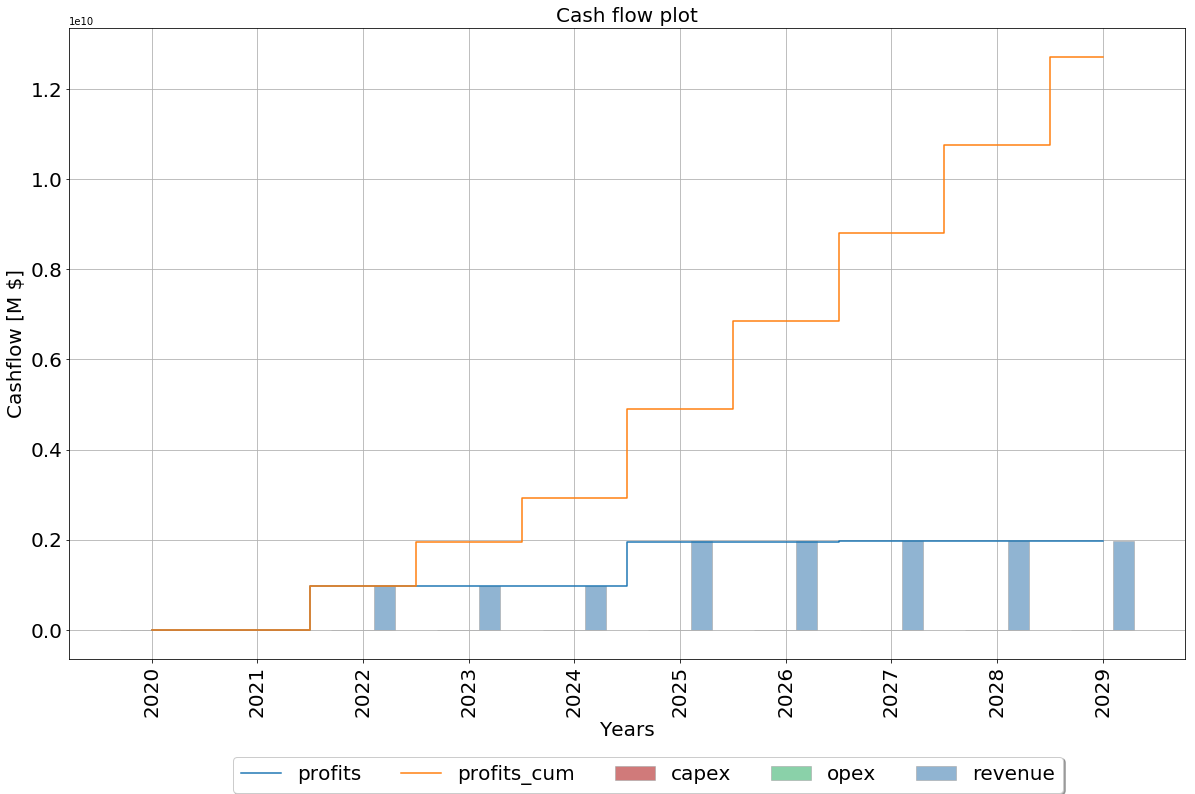

In [12]:
plot.cashflow_plot(Terminal, cash_flows, title='Cash flow plot')

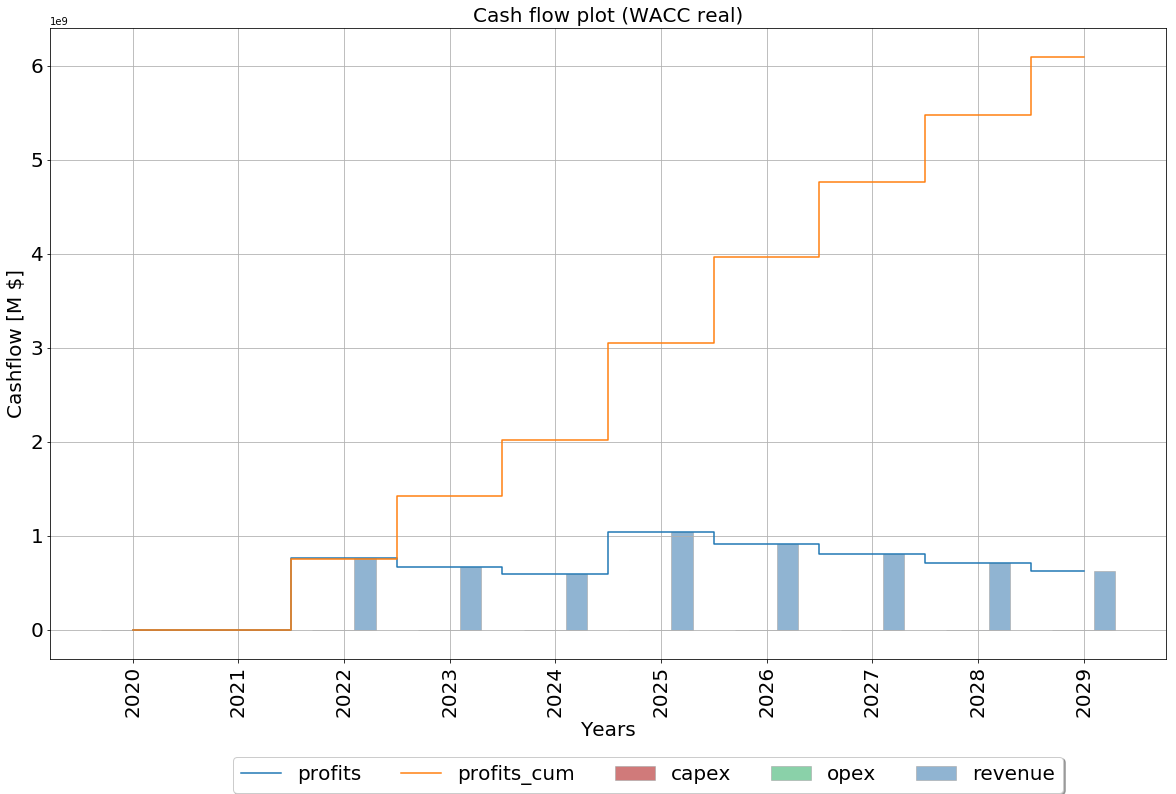

In [13]:
plot.cashflow_plot(Terminal, cash_flows_WACC_real, title='Cash flow plot (WACC real)')

In [17]:
core.NPV(Terminal, Labour)

,CAPEX,OPEX,REVENUES,PV,cum-PV
2020,-2.676000e+06,-0.000000,0.000000e+00,-2.676000e+06,-2.676000e+06
2021,-1.570856e+06,-0.000000,0.000000e+00,-1.570856e+06,-4.246856e+06
2022,-0.000000e+00,-525437.096748,7.598176e+08,7.592921e+08,7.550453e+08
2023,-0.000000e+00,-462660.427040,6.690382e+08,6.685756e+08,1.423621e+09
2024,-0.000000e+00,-407384.008616,5.891048e+08,5.886974e+08,2.012318e+09
2025,-1.416427e+06,-358711.747918,1.037443e+09,1.035668e+09,3.047986e+09
2026,-8.314662e+05,-315854.612290,9.134942e+08,9.123469e+08,3.960333e+09
2027,-0.000000e+00,-306516.473136,8.043544e+08,8.040479e+08,4.764381e+09
2028,-0.000000e+00,-269895.375172,7.082540e+08,7.079841e+08,5.472365e+09
2029,-0.000000e+00,-237649.587945,6.236353e+08,6.233976e+08,6.095763e+09
